In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
# os.chdir("drive/My Drive/rf_signals/recordings_real/honda/model/MobileNet")
os.chdir("drive/My Drive/model/MobileNet")

In [4]:
!ls

mobilenetv1_fft_aug.pkl  mobilenetv2_fft_aug.pkl  mobilenetv2_fft.pt  model.py
mobilenetv1.pth		 mobilenetv2_fft.pkl	  model.ipynb	      quantized_mobilenetv1.pth


In [ ]:
!ls ..

create_dataset.py  MobileNet		ResNet
datasets	   model.py		RTL-SDR-20240412_120507-433_92MHz-2MSps-2MHz.complex
helpers		   perturbations.ipynb	TimesFM
MCUNet		   requirements.txt


### MobileNetV2

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
import time

class DOCMobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super(DOCMobileNetV2, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        num_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier[1] = nn.Linear(num_features, num_classes)
        self.losses = []

    def forward(self, x):
        return self.mobilenet(x)

class CompactnessLoss(nn.Module):
    def __init__(self):
        super(CompactnessLoss, self).__init__()

    def forward(self, x):
        # n is the batch size, k is the number of features
        n, k = x.size()
        means = x.mean(dim=0, keepdim=True)
        squared_diff = (x - means).pow(2)
        variance = squared_diff.sum() / (n * k)
        return variance

class DOCDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal, label = self.data[idx]

        if isinstance(signal, np.ndarray):
            if signal.ndim == 3:
                signal = Image.fromarray(signal.astype(np.uint8), mode='RGB')
            elif signal.ndim == 2:
                signal = Image.fromarray(signal.astype(np.uint8), mode='L')
            else:
                raise TypeError(f"Unexpected shape {signal.shape} for input data")

        if self.transform:
            signal = self.transform(signal)

        return signal, label

class DistillationLoss(nn.Module):
    def __init__(self, temperature=3.0):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature

    def forward(self, student_outputs, teacher_outputs, targets):
        soft_targets = nn.functional.softmax(teacher_outputs / self.temperature, dim=1)
        student_logits = nn.functional.log_softmax(student_outputs / self.temperature, dim=1)
        distillation_loss = nn.functional.kl_div(student_logits, soft_targets, reduction="batchmean") * (self.temperature ** 2)

        ce_loss = nn.CrossEntropyLoss()(student_outputs, targets)
        return distillation_loss + ce_loss

def train_student(student_model, teacher_model, reference_loader, target_loader, num_epochs, learning_rate, lambda_val):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    student_model.to(device)
    teacher_model.to(device)

    optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)
    distillation_loss_fn = DistillationLoss(temperature=3.0)
    compactness_loss_fn = CompactnessLoss()

    for epoch in range(num_epochs):
        student_model.losses.append([])
        student_model.train()
        desc_loss_accum = comp_loss_accum = dist_loss_accum = 0.0

        for (ref_inputs, ref_labels), (target_inputs, _) in zip(reference_loader, target_loader):
            ref_inputs, ref_labels = ref_inputs.to(device), ref_labels.to(device)
            target_inputs = target_inputs.to(device)

            optimizer.zero_grad()

            # Teacher's output on the reference inputs
            with torch.no_grad():
                teacher_outputs = teacher_model(ref_inputs)

            # Student's output on the reference inputs
            student_outputs = student_model(ref_inputs)
            dist_loss = distillation_loss_fn(student_outputs, teacher_outputs, ref_labels)
            dist_loss.backward(retain_graph=True)
            dist_grads = [p.grad.clone() for p in student_model.parameters()]
            dist_loss_accum += dist_loss.item()
            desc_loss = nn.CrossEntropyLoss()(student_outputs, ref_labels)
            # desc_loss_accum += desc_loss.item()

            # Target dataset forward pass with compactness loss
            optimizer.zero_grad()
            student_target_outputs = student_model(target_inputs)
            comp_loss = compactness_loss_fn(student_target_outputs)
            comp_loss.backward()
            comp_grads = [p.grad.clone() for p in student_model.parameters()]
            comp_loss_accum += comp_loss.item()

            # Combine gradients from distillation and compactness loss
            for p, dg, cg in zip(student_model.parameters(), dist_grads, comp_grads):
                p.grad = (dg + cg) / 2

            optimizer.step()
            student_model.losses[-1].append((dist_loss.item(), comp_loss.item(),desc_loss.item()))

        print(f"Epoch [{epoch+1}/{num_epochs}], Distillation Loss: {dist_loss_accum:.4f}, Compactness Loss: {comp_loss_accum:.4f}")

teacher_model = torch.jit.load("../ResNet/resnet_fft_aug.pt")
teacher_model.eval()  # set teacher model to evaluation mode

num_classes = 1000  # same number of classes as in ImageNet
model = DOCMobileNetV2(num_classes)

# datasets: legitimate, reconstructed, attack, augmented legitimate signals
dataset_type = ['constellation/','fft/']
datasets_directory = '../datasets/' + dataset_type[1]

print("Dataset type:", dataset_type[1][:-1])
print("Loading datasets...")

with open(datasets_directory + 'reconstructed7.npy','rb') as f:
    reconstructed_attack = []
    signal = np.load(f)
    while True:
        try:
            signal = np.load(f)
            reconstructed_attack.append(signal)
        except:
            break

with open(datasets_directory + 'legitimate.npy','rb') as f:
    legitimate = []
    signal = np.load(f)
    while True:
        try:
            signal = np.load(f)
            legitimate.append(signal)
        except:
            break

with open(datasets_directory + 'attack1.npy','rb') as f:
    attack1 = []
    while True:
        try:
            signal = np.load(f)
            attack1.append(signal)
        except:
            break

with open(datasets_directory + 'attack2.npy','rb') as f:
    attack2 = []
    while True:
        try:
            signal = np.load(f)
            attack2.append(signal)
        except:
            break

with open(datasets_directory + 'augmented_legitimate7.npy','rb') as f:
    augmented_legitimate = []
    while True:
        try:
            signal = np.load(f)
            augmented_legitimate.append(signal)
        except:
            break
legitimate = [(signal, 0) for signal in legitimate]
augmented_legitimate = [(signal, 0) for signal in augmented_legitimate]
reconstructed_attack = [(signal, 1) for signal in reconstructed_attack]
attack1 = [(signal, 1) for signal in attack1]
attack2 = [(signal, 1) for signal in attack2]
reference_dataset = augmented_legitimate + reconstructed_attack
target_dataset = augmented_legitimate

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

reference_dataset = DOCDataset(reference_dataset, transform=transform)
reference_loader = DataLoader(reference_dataset, batch_size=32, shuffle=True)

target_dataset = DOCDataset(target_dataset, transform=transform)
target_loader = DataLoader(target_dataset, batch_size=32, shuffle=True)

num_epochs = 120
learning_rate = 0.0001
lambda_val = 0.5

print("dataset size:",len(reference_dataset),len(target_dataset))

start = time.time()
train_student(model, teacher_model, reference_loader, target_loader, num_epochs, learning_rate, lambda_val)
print("training runtime:",time.time()-start)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 55.0MB/s]


Dataset type: fft
Loading datasets...
dataset size: 1198 500
Epoch [1/120], Distillation Loss: 116.9335, Compactness Loss: 0.7901
Epoch [2/120], Distillation Loss: 33.7766, Compactness Loss: 0.9107
Epoch [3/120], Distillation Loss: 14.0781, Compactness Loss: 0.5941
Epoch [4/120], Distillation Loss: 4.9727, Compactness Loss: 0.5274
Epoch [5/120], Distillation Loss: 3.7424, Compactness Loss: 0.5087
Epoch [6/120], Distillation Loss: 3.3579, Compactness Loss: 0.4694
Epoch [7/120], Distillation Loss: 3.0365, Compactness Loss: 0.5499
Epoch [8/120], Distillation Loss: 2.8011, Compactness Loss: 0.4911
Epoch [9/120], Distillation Loss: 2.2945, Compactness Loss: 0.4837
Epoch [10/120], Distillation Loss: 2.5538, Compactness Loss: 0.4611
Epoch [11/120], Distillation Loss: 1.7331, Compactness Loss: 0.4528
Epoch [12/120], Distillation Loss: 1.0663, Compactness Loss: 0.4559
Epoch [13/120], Distillation Loss: 0.8645, Compactness Loss: 0.4454
Epoch [14/120], Distillation Loss: 0.7675, Compactness Loss:

In [ ]:
!pip install pytorchcv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.2/134.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.2/585.2 kB 38.1 MB/s eta 0:00:00


### MobileNetV1

In [ ]:
!pip install pytorchcv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.2/134.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.2/585.2 kB 21.7 MB/s eta 0:00:00


In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from pytorchcv.model_provider import get_model as ptcv_get_model
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
import time

class DOCMobileNetV1(nn.Module):
    def __init__(self, num_classes):
        super(DOCMobileNetV1, self).__init__()
        # Load pretrained MobileNetV1 from pytorchcv
        self.mobilenet = ptcv_get_model("mobilenet_w1", pretrained=True)
        num_features = self.mobilenet.output.in_features
        self.mobilenet.output = nn.Linear(num_features, num_classes)
        self.losses = []

    def forward(self, x):
        return self.mobilenet(x)

class CompactnessLoss(nn.Module):
    def __init__(self):
        super(CompactnessLoss, self).__init__()

    def forward(self, x):
        # n is the batch size, k is the number of features
        n, k = x.size()
        means = x.mean(dim=0, keepdim=True)
        squared_diff = (x - means).pow(2)
        variance = squared_diff.sum() / (n * k)
        return variance

class DOCDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal, label = self.data[idx]

        if isinstance(signal, np.ndarray):
            if signal.ndim == 3:
                signal = Image.fromarray(signal.astype(np.uint8), mode='RGB')
            elif signal.ndim == 2:
                signal = Image.fromarray(signal.astype(np.uint8), mode='L')
            else:
                raise TypeError(f"Unexpected shape {signal.shape} for input data")

        if self.transform:
            signal = self.transform(signal)

        return signal, label

class DistillationLoss(nn.Module):
    def __init__(self, temperature=3.0):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature

    def forward(self, student_outputs, teacher_outputs, targets):
        soft_targets = nn.functional.softmax(teacher_outputs / self.temperature, dim=1)
        student_logits = nn.functional.log_softmax(student_outputs / self.temperature, dim=1)
        distillation_loss = nn.functional.kl_div(student_logits, soft_targets, reduction="batchmean") * (self.temperature ** 2)

        ce_loss = nn.CrossEntropyLoss()(student_outputs, targets)
        return distillation_loss + ce_loss

def train_student(student_model, teacher_model, reference_loader, target_loader, num_epochs, learning_rate, lambda_val):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    student_model.to(device)
    teacher_model.to(device)

    optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)
    distillation_loss_fn = DistillationLoss(temperature=3.0)
    compactness_loss_fn = CompactnessLoss()

    for epoch in range(num_epochs):
        student_model.losses.append([])
        student_model.train()
        desc_loss_accum = comp_loss_accum = dist_loss_accum = 0.0

        for (ref_inputs, ref_labels), (target_inputs, _) in zip(reference_loader, target_loader):
            ref_inputs, ref_labels = ref_inputs.to(device), ref_labels.to(device)
            target_inputs = target_inputs.to(device)

            optimizer.zero_grad()

            # Teacher's output on the reference inputs
            with torch.no_grad():
                teacher_outputs = teacher_model(ref_inputs)

            # Student's output on the reference inputs
            student_outputs = student_model(ref_inputs)
            dist_loss = distillation_loss_fn(student_outputs, teacher_outputs, ref_labels)
            dist_loss.backward(retain_graph=True)
            dist_grads = [p.grad.clone() for p in student_model.parameters()]
            dist_loss_accum += dist_loss.item()
            desc_loss = nn.CrossEntropyLoss()(student_outputs, ref_labels)
            # desc_loss_accum += desc_loss.item()

            # Target dataset forward pass with compactness loss
            optimizer.zero_grad()
            student_target_outputs = student_model(target_inputs)
            comp_loss = compactness_loss_fn(student_target_outputs)
            comp_loss.backward()
            comp_grads = [p.grad.clone() for p in student_model.parameters()]
            comp_loss_accum += comp_loss.item()

            # Combine gradients from distillation and compactness loss
            for p, dg, cg in zip(student_model.parameters(), dist_grads, comp_grads):
                p.grad = (dg + cg) / 2

            optimizer.step()
            student_model.losses[-1].append((dist_loss.item(), comp_loss.item(),desc_loss.item()))

        print(f"Epoch [{epoch+1}/{num_epochs}], Distillation Loss: {dist_loss_accum:.4f}, Compactness Loss: {comp_loss_accum:.4f}")

teacher_model = torch.jit.load("../ResNet/resnet_fft_aug.pt")
teacher_model.eval()  # set teacher model to evaluation mode

num_classes = 1000  # same number of classes as in ImageNet
model = DOCMobileNetV1(num_classes)

# datasets: legitimate, reconstructed, attack, augmented legitimate signals
dataset_type = ['constellation/','fft/']
datasets_directory = '../datasets/' + dataset_type[1]

print("Dataset type:", dataset_type[1][:-1])
print("Loading datasets...")

with open(datasets_directory + 'reconstructed7.npy','rb') as f:
    reconstructed_attack = []
    signal = np.load(f)
    while True:
        try:
            signal = np.load(f)
            reconstructed_attack.append(signal)
        except:
            break

with open(datasets_directory + 'legitimate.npy','rb') as f:
    legitimate = []
    signal = np.load(f)
    while True:
        try:
            signal = np.load(f)
            legitimate.append(signal)
        except:
            break

with open(datasets_directory + 'attack1.npy','rb') as f:
    attack1 = []
    while True:
        try:
            signal = np.load(f)
            attack1.append(signal)
        except:
            break

with open(datasets_directory + 'attack2.npy','rb') as f:
    attack2 = []
    while True:
        try:
            signal = np.load(f)
            attack2.append(signal)
        except:
            break

with open(datasets_directory + 'augmented_legitimate7.npy','rb') as f:
    augmented_legitimate = []
    while True:
        try:
            signal = np.load(f)
            augmented_legitimate.append(signal)
        except:
            break
legitimate = [(signal, 0) for signal in legitimate]
augmented_legitimate = [(signal, 0) for signal in augmented_legitimate]
reconstructed_attack = [(signal, 1) for signal in reconstructed_attack]
attack1 = [(signal, 1) for signal in attack1]
attack2 = [(signal, 1) for signal in attack2]
reference_dataset = augmented_legitimate + reconstructed_attack
target_dataset = augmented_legitimate

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

reference_dataset = DOCDataset(reference_dataset, transform=transform)
reference_loader = DataLoader(reference_dataset, batch_size=32, shuffle=True)

target_dataset = DOCDataset(target_dataset, transform=transform)
target_loader = DataLoader(target_dataset, batch_size=32, shuffle=True)

num_epochs = 120
learning_rate = 0.0001
lambda_val = 0.5

print("dataset size:",len(reference_dataset),len(target_dataset))

start = time.time()
# train_student(model, teacher_model, reference_loader, target_loader, num_epochs, learning_rate, lambda_val)
print("training runtime:",time.time()-start)

Dataset type: fft
Loading datasets...
dataset size: 1198 500
training runtime: 2.7894973754882812e-05


### QAT MobileNetV1

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from pytorchcv.model_provider import get_model as ptcv_get_model
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
import time
from torch.quantization import QuantStub, DeQuantStub, fuse_modules, prepare_qat, convert

class DOCMobileNetV1(nn.Module):
    def __init__(self, num_classes):
        super(DOCMobileNetV1, self).__init__()
        base_model = ptcv_get_model("mobilenet_w1", pretrained=True)

        # Restructure the model for QAT
        self.features = base_model.features
        self.classifier = base_model.output

        # Adjust the classifier for your number of classes
        num_features = self.classifier.in_features
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(num_features, num_classes)
        )

        # Add quantization stubs
        self.quant = QuantStub()
        self.dequant = DeQuantStub()

        self.losses = []

    def forward(self, x):
        x = self.quant(x)
        x = self.features(x)
        # Global average pooling
        x = torch.mean(x, dim=(2, 3))
        x = self.classifier(x)
        x = self.dequant(x)
        return x

    def fuse_model(self):
        """
        Fuse Conv+BN+ReLU modules in the model for better quantization
        """
        for m in self.modules():
            if type(m) == nn.Sequential:
                for i in range(len(m) - 2):
                    if (isinstance(m[i], nn.Conv2d) and
                        isinstance(m[i + 1], nn.BatchNorm2d) and
                        isinstance(m[i + 2], nn.ReLU)):
                        torch.quantization.fuse_modules(m, [str(i), str(i + 1), str(i + 2)], inplace=True)

class CompactnessLoss(nn.Module):
    def __init__(self):
        super(CompactnessLoss, self).__init__()

    def forward(self, x):
        # n is the batch size, k is the number of features
        n, k = x.size()
        means = x.mean(dim=0, keepdim=True)
        squared_diff = (x - means).pow(2)
        variance = squared_diff.sum() / (n * k)
        return variance

class DOCDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal, label = self.data[idx]

        if isinstance(signal, np.ndarray):
            if signal.ndim == 3:
                signal = Image.fromarray(signal.astype(np.uint8), mode='RGB')
            elif signal.ndim == 2:
                signal = Image.fromarray(signal.astype(np.uint8), mode='L')
            else:
                raise TypeError(f"Unexpected shape {signal.shape} for input data")

        if self.transform:
            signal = self.transform(signal)

        return signal, label

class DistillationLoss(nn.Module):
    def __init__(self, temperature=3.0):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature

    def forward(self, student_outputs, teacher_outputs, targets):
        soft_targets = nn.functional.softmax(teacher_outputs / self.temperature, dim=1)
        student_logits = nn.functional.log_softmax(student_outputs / self.temperature, dim=1)
        distillation_loss = nn.functional.kl_div(student_logits, soft_targets, reduction="batchmean") * (self.temperature ** 2)

        ce_loss = nn.CrossEntropyLoss()(student_outputs, targets)
        return distillation_loss + ce_loss

def train_student(student_model, teacher_model, reference_loader, target_loader, num_epochs, learning_rate, lambda_val):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move models to CPU for QAT (QAT requires CPU)
    student_model = student_model.cpu()
    teacher_model = teacher_model.cpu()

    optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)
    distillation_loss_fn = DistillationLoss(temperature=3.0)
    compactness_loss_fn = CompactnessLoss()

    # Prepare model for QAT
    student_model.train()

    # Fuse layers
    student_model.fuse_model()

    # Set QAT configuration
    student_model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')

    # Prepare the model for QAT
    prepare_qat(student_model, inplace=True)

    for epoch in range(num_epochs):
        student_model.losses.append([])
        student_model.train()
        desc_loss_accum = comp_loss_accum = dist_loss_accum = 0.0

        for batch_idx, ((ref_inputs, ref_labels), (target_inputs, _)) in enumerate(zip(reference_loader, target_loader)):
            # Move data to CPU for QAT
            ref_inputs, ref_labels = ref_inputs.cpu(), ref_labels.cpu()
            target_inputs = target_inputs.cpu()

            optimizer.zero_grad()

            # Teacher's output
            with torch.no_grad():
                teacher_outputs = teacher_model(ref_inputs)

            # Student's output
            student_outputs = student_model(ref_inputs)
            dist_loss = distillation_loss_fn(student_outputs, teacher_outputs, ref_labels)
            dist_loss.backward(retain_graph=True)
            desc_grads = [p.grad.clone() for p in student_model.parameters()]
            dist_loss_accum += dist_loss.item()

            # Target dataset forward pass
            optimizer.zero_grad()
            student_target_outputs = student_model(target_inputs)
            comp_loss = compactness_loss_fn(student_target_outputs)
            comp_loss.backward()
            comp_grads = [p.grad.clone() for p in student_model.parameters()]
            comp_loss_accum += comp_loss.item()

            # Combine gradients
            for p, dg, cg in zip(student_model.parameters(), desc_grads, comp_grads):
                if p.grad is not None:
                    p.grad = (dg + lambda_val * cg)

            optimizer.step()
            student_model.losses[-1].append((dist_loss.item(), comp_loss.item()))

        print(f"Epoch [{epoch+1}/{num_epochs}], Distillation Loss: {dist_loss_accum:.4f}, Compactness Loss: {comp_loss_accum:.4f}")

    # Convert to quantized model
    student_model.eval()
    student_model = torch.quantization.convert(student_model, inplace=True)

    return student_model

teacher_model = torch.jit.load("../ResNet/resnet_fft.pt")
teacher_model.eval()  # set teacher model to evaluation mode

num_classes = 1000  # same number of classes as in ImageNet
model = DOCMobileNetV1(num_classes)

# datasets: legitimate, reconstructed, attack, augmented legitimate signals
dataset_type = ['constellation/','fft/']
datasets_directory = '../datasets/' + dataset_type[1]

print("Dataset type:", dataset_type[1][:-1])
print("Loading datasets...")

with open(datasets_directory + 'reconstructed.npy','rb') as f:
    reconstructed_attack = []
    signal = np.load(f)
    while True:
        try:
            signal = np.load(f)
            reconstructed_attack.append(signal)
        except:
            break

with open(datasets_directory + 'legitimate.npy','rb') as f:
    legitimate = []
    signal = np.load(f)
    while True:
        try:
            signal = np.load(f)
            legitimate.append(signal)
        except:
            break

with open(datasets_directory + 'attack1.npy','rb') as f:
    attack1 = []
    while True:
        try:
            signal = np.load(f)
            attack1.append(signal)
        except:
            break

with open(datasets_directory + 'attack2.npy','rb') as f:
    attack2 = []
    while True:
        try:
            signal = np.load(f)
            attack2.append(signal)
        except:
            break

with open(datasets_directory + 'augmented_legitimate.npy','rb') as f:
    augmented_legitimate = []
    while True:
        try:
            signal = np.load(f)
            augmented_legitimate.append(signal)
        except:
            break
legitimate = [(signal, 0) for signal in legitimate]
augmented_legitimate = [(signal, 0) for signal in augmented_legitimate]
reconstructed_attack = [(signal, 1) for signal in reconstructed_attack]
attack1 = [(signal, 1) for signal in attack1]
attack2 = [(signal, 1) for signal in attack2]
reference_dataset = augmented_legitimate + reconstructed_attack
target_dataset = augmented_legitimate

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

reference_dataset = DOCDataset(reference_dataset, transform=transform)
reference_loader = DataLoader(reference_dataset, batch_size=32, shuffle=True)

target_dataset = DOCDataset(target_dataset, transform=transform)
target_loader = DataLoader(target_dataset, batch_size=32, shuffle=True)

num_epochs = 120
learning_rate = 0.0001
lambda_val = 0.5

print("dataset size:",len(reference_dataset),len(target_dataset))

start = time.time()
train_student(model, teacher_model, reference_loader, target_loader, num_epochs, learning_rate, lambda_val)
print("training runtime:",time.time()-start)

Dataset type: fft
Loading datasets...
dataset size: 1198 500
training runtime: 2.47955322265625e-05


In [ ]:
torch.save(model.state_dict(), "mobilenetv1.pth")

In [ ]:
!ls

mobilenetv1.pth  mobilenetv2_fft.pkl  mobilenetv2_fft.pt  model.ipynb  model.py


### Quantization on mobilenetv1

In [ ]:
import torch.quantization as quant

# Prepare the model for quantization
def quantize_model(model):
    model.eval()

    # 1. Fuse any necessary layers (if applicable). For MobileNet, this may not be required.
    # model.fuse_model() # Uncomment if layer fusion is required

    # 2. Specify quantization configuration
    model.qconfig = quant.get_default_qconfig('fbgemm')

    # 3. Prepare the model for static quantization
    quant.prepare(model, inplace=True)

    # Calibrate the model with representative data from the target dataset
    with torch.no_grad():
        for inputs, _ in target_loader:
            model(inputs)

    # 4. Convert to quantized version
    quant.convert(model, inplace=True)

    return model

quantized_model = quantize_model(model)

quantized_model_path = 'quantized_mobilenetv1.pth'
torch.save(quantized_model.state_dict(), quantized_model_path)
quantized_size = os.path.getsize(quantized_model_path) / (1024 * 1024)
print(f"Quantized model size: {quantized_size:.2f} MB")


/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Quantized model size: 4.48 MB


Load the saved quantized model

In [ ]:
import torch
from torchvision import models
import torch.nn as nn
import os

class DOCMobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super(DOCMobileNetV2, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        num_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier[1] = nn.Linear(num_features, num_classes)
        self.losses = []

    def forward(self, x):
        return self.mobilenet(x)

def load_quantized_model(path, num_classes):
    model = DOCMobileNetV2(num_classes)
    model.qconfig = torch.quantization.get_default_qconfig('fbgemm')

    torch.quantization.prepare(model, inplace=True)
    torch.quantization.convert(model, inplace=True)

    model.load_state_dict(torch.load(path))
    model.eval()

    return model

quantized_model_path = 'quantized_mobilenetv1.pth'
num_classes = 1000
quantized_model = load_quantized_model(quantized_model_path, num_classes)

In [ ]:
# from pytorchcv.model_provider import get_model as ptcv_get_model
# import torch
# import torch.quantization as quant

# # Prepare the model for quantization
# def quantize_model(model):
#     model.eval()

#     # 1. Fuse any necessary layers (if applicable). For MobileNet, this may not be required.
#     # model.fuse_model() # Uncomment if layer fusion is required

#     # 2. Specify quantization configuration
#     model.qconfig = quant.get_default_qconfig('fbgemm')

#     # 3. Prepare the model for static quantization
#     quant.prepare(model, inplace=True)

#     # Calibrate the model with representative data from the target dataset
#     with torch.no_grad():
#         for inputs, _ in target_loader:
#             model(inputs)

#     # 4. Convert to quantized version
#     quant.convert(model, inplace=True)

#     return model


# model = ptcv_get_model("mobilenet_w1",pretrained=True)
# # Apply quantization to your MobileNetV1 model
# quantized_model1 = quantize_model(model)

# # Verify storage requirement by saving the model
# quantize_model1.weights()


In [ ]:
quantized_model

DOCMobileNetV1(
  (mobilenet): MobileNet(
    (features): Sequential(
      (init_block): ConvBlock(
        (conv): QuantizedConv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), scale=0.03398917615413666, zero_point=67, padding=(1, 1), bias=False)
        (bn): QuantizedBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): ReLU(inplace=True)
      )
      (stage1): Sequential(
        (unit1): DwsConvBlock(
          (dw_conv): ConvBlock(
            (conv): QuantizedConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), scale=1.1482387781143188, zero_point=59, padding=(1, 1), groups=32, bias=False)
            (bn): QuantizedBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activ): ReLU(inplace=True)
          )
          (pw_conv): ConvBlock(
            (conv): QuantizedConv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), scale=0.4408669173717499, zero_point=74, bias=False)
            (bn): QuantizedBatchNor

In [ ]:
model_to_script = DOCMobileNetV1(num_classes)
model_to_script.load_state_dict(model.state_dict())

<All keys matched successfully>

augmented mobilenetv1 losses

In [ ]:
model.losses

[[(11.62142562866211, 0.0265080276876688, 6.880489826202393),
  (11.072465896606445, 0.028871413320302963, 6.392672538757324),
  (10.177377700805664, 0.027495145797729492, 5.921398162841797),
  (10.177482604980469, 0.0279459860175848, 5.577524662017822),
  (9.514947891235352, 0.027980925515294075, 5.181386947631836),
  (8.586969375610352, 0.028398986905813217, 4.724184513092041),
  (8.179576873779297, 0.02718806266784668, 4.261050701141357),
  (7.806153774261475, 0.03099093958735466, 3.911646842956543),
  (6.6910200119018555, 0.030349476262927055, 3.499979257583618),
  (7.544095993041992, 0.03107902593910694, 3.407407760620117),
  (6.070072650909424, 0.030416375026106834, 2.7440929412841797),
  (5.653860092163086, 0.031025508418679237, 2.44286847114563),
  (4.968216896057129, 0.03163108602166176, 2.3657114505767822),
  (4.829838752746582, 0.030182087793946266, 1.8058698177337646),
  (4.45091438293457, 0.03256183862686157, 1.518592119216919),
  (3.757660388946533, 0.03267747163772583, 1

In [ ]:
import torch

model_to_script = model_to_script.cpu()
traced_model = torch.jit.script(model_to_script)
traced_model.save("mobilenetv1_fft_aug.pt")

RuntimeError: Can't redefine method: forward on class: __torch__.pytorchcv.models.common.conv.ConvBlock (of Python compilation unit at: 0x582aff8203e0)

In [ ]:
# import pickle

# with open('mobilenetv1_fft_aug.pkl','wb') as f:
#   pickle.dump(model,f)

In [8]:
# import pickle

model.to('cpu')
# with open('mobilenetv2_fft_aug.pkl','wb') as f:
#   pickle.dump(model,f)

In [61]:
import pickle
import torch
import torch.nn as nn
import pytorchcv

class DOCMobileNetV1(nn.Module):
    def __init__(self, num_classes):
        super(DOCMobileNetV1, self).__init__()
        # Load pretrained MobileNetV1 from pytorchcv
        self.mobilenet = ptcv_get_model("mobilenet_w1", pretrained=True)
        num_features = self.mobilenet.output.in_features
        self.mobilenet.output = nn.Linear(num_features, num_classes)
        self.losses = []

    def forward(self, x):
        return self.mobilenet(x)
    
class DOCMobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super(DOCMobileNetV2, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        num_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier[1] = nn.Linear(num_features, num_classes)
        self.losses = []

    def forward(self, x):
        return self.mobilenet(x)

with open('mobilenetv1_fft_aug.pkl','rb') as f:
  mb1 = pickle.load(f)

with open('mobilenetv2_fft_aug.pkl','rb') as f:
  mb2 = pickle.load(f)

In [10]:
# import pickle
# import torch.nn as nn
# import torch

# class DOCMobileNetV2(nn.Module):
#     def __init__(self, num_classes):
#         super(DOCMobileNetV2, self).__init__()
#         self.mobilenet = models.mobilenet_v2(pretrained=True)
#         num_features = self.mobilenet.classifier[1].in_features
#         self.mobilenet.classifier[1] = nn.Linear(num_features, num_classes)
#         self.losses = []

#     def forward(self, x):
#         return self.mobilenet(x)

# model = torch.jit.load("mobilenetv2_fft.pkl", map_location=torch.device('cpu'))

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [ ]:
import torch

model = torch.jit.load("mobilenetv2_fft.pt", map_location=torch.device('cpu'))
model.eval()

In [63]:
# model.to('cpu')
mb1.eval()

def outputs_doc(model, test_loader):
    print("Getting model outputs...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_outputs = []

    with torch.no_grad():
        for ref_inputs, _ in test_loader:
            ref_inputs = ref_inputs.to(device)
            ref_outputs = model(ref_inputs)
            all_outputs.append(ref_outputs.cpu())

    return all_outputs[0]

legitimate_dataset = DOCDataset(legitimate, transform=transform)
legitimate_loader = DataLoader(legitimate_dataset, batch_size=len(legitimate_dataset), shuffle=False)
legitimate_outputs = outputs_doc(mb1, legitimate_loader)
print("legitimate outputs:",len(legitimate_outputs))
# augmented_legitimate_loader = DataLoader(target_dataset, batch_size=len(target_dataset), shuffle=False)
# augmented_legitimate_outputs = outputs_doc(mb2, augmented_legitimate_loader)
# print("augmented legitimate outputs:",len(augmented_legitimate_outputs))
reconstructed_attack_dataset = DOCDataset(reconstructed_attack, transform=transform)
reconstructed_attack_loader = DataLoader(reconstructed_attack_dataset, batch_size=len(reconstructed_attack_dataset), shuffle=False)
reconstructed_attack_outputs = outputs_doc(mb1, reconstructed_attack_loader)
print("Reconstructed attack outputs:",len(reconstructed_attack_outputs))
attack1_dataset = DOCDataset(attack1, transform=transform)
attack1_loader = DataLoader(attack1_dataset, batch_size=len(attack1_dataset), shuffle=False)
attack1_outputs = outputs_doc(mb1, attack1_loader)
print("HackRF One (1) outputs:",len(attack1_outputs))
attack2_dataset = DOCDataset(attack2, transform=transform)
attack2_loader = DataLoader(attack2_dataset, batch_size=len(attack2_dataset), shuffle=False)
attack2_outputs = outputs_doc(mb1, attack2_loader)
print("HackRF One (2) outputs:",len(attack2_outputs))

Getting model outputs...
legitimate outputs: 98
Getting model outputs...
Reconstructed attack outputs: 698
Getting model outputs...
HackRF One (1) outputs: 100
Getting model outputs...
HackRF One (2) outputs: 100


In [68]:
attack2_outputs

8.067079544067383

In [54]:
print(legitimate_outputs[0],len(legitimate_outputs[0]))

tensor([ 8.0005,  0.2573, -3.4780, -2.3247, -2.2339, -2.4754, -3.0445, -2.7699,
        -2.8498, -3.0351, -3.1182, -2.2137, -2.8212, -2.1687, -2.5982, -2.5251,
        -3.3571, -3.2278, -2.9305, -2.5344, -3.0970, -2.6969, -2.6038, -2.8429,
        -2.1347, -2.4400, -2.3170, -2.1508, -2.1374, -2.8670, -2.9295, -3.0790,
        -2.9092, -2.8166, -2.6332, -3.0673, -2.9649, -2.4697, -3.3804, -2.2548,
        -2.5164, -3.4517, -2.9655, -1.8613, -2.1558, -2.6711, -2.9141, -2.5628,
        -2.3618, -2.7681, -2.9589, -2.7910, -3.2606, -2.0433, -2.6137, -2.3983,
        -2.3371, -2.8130, -3.3518, -1.9083, -2.8215, -3.0849, -2.4594, -2.7316,
        -2.4002, -2.3683, -2.8103, -2.2728, -3.3622, -3.0746, -2.6187, -2.6804,
        -2.8391, -2.1460, -2.5854, -1.8939, -2.3231, -2.2687, -2.2499, -3.0534,
        -2.0953, -2.7964, -2.7964, -2.9108, -2.4897, -2.3817, -2.2578, -2.7718,
        -2.6074, -2.6191, -3.1221, -2.1897, -2.5088, -3.0114, -2.3309, -2.9089,
        -3.2829, -2.4482, -2.9137, -2.29

In [72]:
attack1_outputs.shape

torch.Size([100, 1000])

## FFT Dataset

Results with aug_legitimate = 200, reconstructed_attack = 200

### MobileNetV2

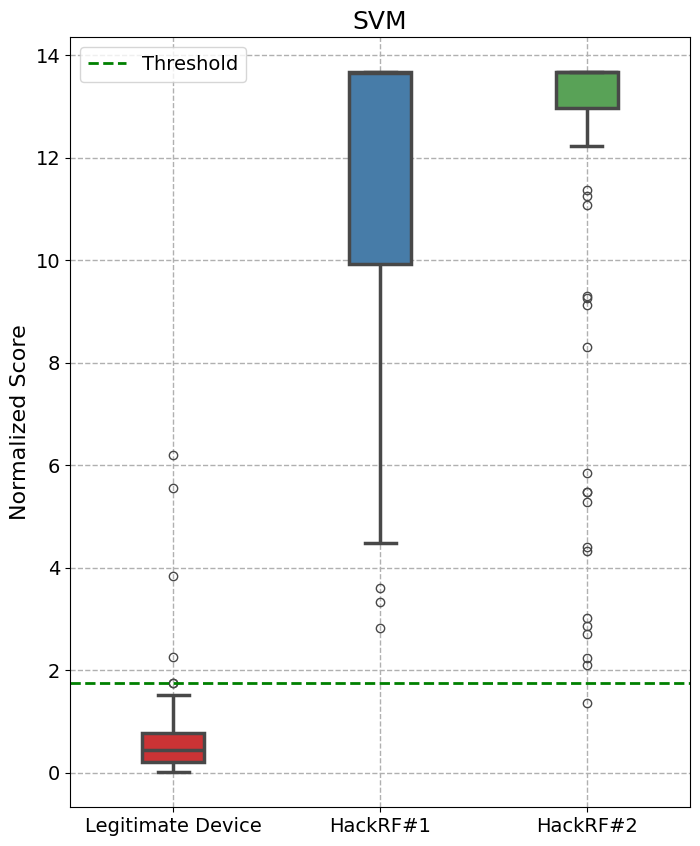

Classification Report for SVM
              precision    recall  f1-score   support

  Legitimate       0.99      0.95      0.97        98
      Attack       0.98      0.99      0.99       200

    accuracy                           0.98       298
   macro avg       0.98      0.97      0.98       298
weighted avg       0.98      0.98      0.98       298



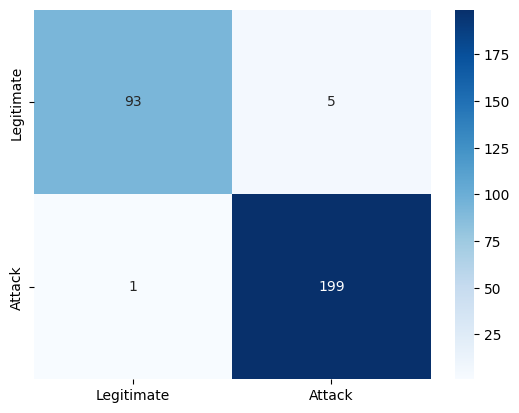

In [ ]:
# One class SVM
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

scaler = StandardScaler()

def train_svm_and_get_scores(X_train, X_test):
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    clf = svm.OneClassSVM(kernel='rbf',nu=0.1)
    clf.fit(X_train)
    scores = clf.decision_function(X_test)
    return scores

X_train, X_test = train_test_split(augmented_legitimate_outputs, test_size=0.3, random_state=42)

aug_legitimate_scores = train_svm_and_get_scores(X_train, X_test)

mu = np.mean(aug_legitimate_scores)
sigma = np.std(aug_legitimate_scores)

legitimate_scores = train_svm_and_get_scores(X_train, legitimate_outputs)

legitimate_scores_norm = np.abs((legitimate_scores - mu) / sigma)

thresholdsvm = np.percentile(legitimate_scores_norm, 95)
legitimate_predictions = (legitimate_scores_norm > thresholdsvm).astype(int)

def evaluate_attack_outputs(attack_outputs, device_name):
    scores = train_svm_and_get_scores(X_train, attack_outputs)
    scores_norm = np.abs((scores - mu) / sigma)
    predictions = (scores_norm > thresholdsvm).astype(int)
    y_test = np.ones(len(attack_outputs))  # True labels for attack outputs
    return scores_norm, predictions, y_test

hackrf1_scores, svmhackrf1_pred, hackrf1_true = evaluate_attack_outputs(attack1_outputs, 'HackRF1')
hackrf2_scores, svmhackrf2_pred, hackrf2_true = evaluate_attack_outputs(attack2_outputs, 'HackRF2')

combined_predictions = np.concatenate([legitimate_predictions,svmhackrf1_pred, svmhackrf2_pred])
true_labels = np.concatenate([np.zeros_like(legitimate_predictions), hackrf1_true, hackrf2_true])

plot_data = [
    legitimate_scores_norm,
    hackrf1_scores,
    hackrf2_scores
]

plt.figure(figsize=(8, 10))
colors = sns.color_palette("Set1", n_colors=3)

sns.boxplot(data=plot_data, width=0.3, palette=colors, linewidth=2.5)
plt.axhline(y=thresholdsvm, color='g', linestyle='--', linewidth=2, label='Threshold')
plt.xticks([0, 1, 2], ['Legitimate Device', 'HackRF#1', 'HackRF#2'], fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Normalized Score', fontsize=16)
plt.title('SVM', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', linewidth=1)
plt.show()

print("Classification Report for SVM")
print(classification_report(true_labels, combined_predictions, target_names=['Legitimate', 'Attack']))

cm = confusion_matrix(true_labels, combined_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Attack'], yticklabels=['Legitimate', 'Attack'])


X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf = svm.OneClassSVM(kernel='rbf',nu=0.1)
clf.fit(X_train)
scores = clf.decision_function(X_test)

Dataset type: fft
Loading datasets...
dataset size: 398 200
Epoch [1/150], Distillation Loss: 83.9222, Compactness Loss: 0.3000
Epoch [2/150], Distillation Loss: 55.2911, Compactness Loss: 0.3357
Epoch [3/150], Distillation Loss: 34.3194, Compactness Loss: 0.4186
Epoch [4/150], Distillation Loss: 21.9955, Compactness Loss: 0.4969
Epoch [5/150], Distillation Loss: 12.4640, Compactness Loss: 0.3951
Epoch [6/150], Distillation Loss: 7.8847, Compactness Loss: 0.2830
Epoch [7/150], Distillation Loss: 5.4785, Compactness Loss: 0.2347
Epoch [8/150], Distillation Loss: 4.5340, Compactness Loss: 0.2170
Epoch [9/150], Distillation Loss: 3.8690, Compactness Loss: 0.2165
Epoch [10/150], Distillation Loss: 3.8661, Compactness Loss: 0.2138
Epoch [11/150], Distillation Loss: 4.6998, Compactness Loss: 0.2275
Epoch [12/150], Distillation Loss: 1.4533, Compactness Loss: 0.2026
Epoch [13/150], Distillation Loss: 3.2722, Compactness Loss: 0.2008
Epoch [14/150], Distillation Loss: 2.2604, Compactness Loss: 0.2095
Epoch [15/150], Distillation Loss: 2.8327, Compactness Loss: 0.2681
Epoch [16/150], Distillation Loss: 1.8807, Compactness Loss: 0.2034
Epoch [17/150], Distillation Loss: 1.0705, Compactness Loss: 0.2075
Epoch [18/150], Distillation Loss: 2.3981, Compactness Loss: 0.2110
Epoch [19/150], Distillation Loss: 1.2390, Compactness Loss: 0.1976
Epoch [20/150], Distillation Loss: 1.5615, Compactness Loss: 0.2107
Epoch [21/150], Distillation Loss: 2.2426, Compactness Loss: 0.1987
Epoch [22/150], Distillation Loss: 1.8382, Compactness Loss: 0.2060
Epoch [23/150], Distillation Loss: 1.3549, Compactness Loss: 0.1984
Epoch [24/150], Distillation Loss: 0.9903, Compactness Loss: 0.1879
Epoch [25/150], Distillation Loss: 1.1162, Compactness Loss: 0.2010
Epoch [26/150], Distillation Loss: 0.6727, Compactness Loss: 0.1919
Epoch [27/150], Distillation Loss: 0.5745, Compactness Loss: 0.1900
Epoch [28/150], Distillation Loss: 0.8350, Compactness Loss: 0.1867
Epoch [29/150], Distillation Loss: 0.5002, Compactness Loss: 0.1868
Epoch [30/150], Distillation Loss: 1.0260, Compactness Loss: 0.1799
Epoch [31/150], Distillation Loss: 0.5230, Compactness Loss: 0.1809
Epoch [32/150], Distillation Loss: 0.6414, Compactness Loss: 0.1815
Epoch [33/150], Distillation Loss: 0.3791, Compactness Loss: 0.1791
Epoch [34/150], Distillation Loss: 0.4855, Compactness Loss: 0.1774
Epoch [35/150], Distillation Loss: 0.6883, Compactness Loss: 0.1768
Epoch [36/150], Distillation Loss: 0.4035, Compactness Loss: 0.1769
Epoch [37/150], Distillation Loss: 0.4856, Compactness Loss: 0.1726
Epoch [38/150], Distillation Loss: 0.5027, Compactness Loss: 0.1704
Epoch [39/150], Distillation Loss: 0.3690, Compactness Loss: 0.1717
Epoch [40/150], Distillation Loss: 0.5338, Compactness Loss: 0.1743
Epoch [41/150], Distillation Loss: 0.3590, Compactness Loss: 0.1690
Epoch [42/150], Distillation Loss: 0.3697, Compactness Loss: 0.1657
Epoch [43/150], Distillation Loss: 0.3189, Compactness Loss: 0.1649
Epoch [44/150], Distillation Loss: 0.7049, Compactness Loss: 0.1653
Epoch [45/150], Distillation Loss: 1.6643, Compactness Loss: 0.1665
Epoch [46/150], Distillation Loss: 0.4096, Compactness Loss: 0.1712
Epoch [47/150], Distillation Loss: 0.4575, Compactness Loss: 0.1682
Epoch [48/150], Distillation Loss: 0.3637, Compactness Loss: 0.1678
Epoch [49/150], Distillation Loss: 0.9134, Compactness Loss: 0.1668
Epoch [50/150], Distillation Loss: 0.3517, Compactness Loss: 0.1643
Epoch [51/150], Distillation Loss: 0.3483, Compactness Loss: 0.1620
Epoch [52/150], Distillation Loss: 0.3420, Compactness Loss: 0.1604
Epoch [53/150], Distillation Loss: 0.3487, Compactness Loss: 0.1597
Epoch [54/150], Distillation Loss: 0.6052, Compactness Loss: 0.1597
Epoch [55/150], Distillation Loss: 0.4842, Compactness Loss: 0.1617
Epoch [56/150], Distillation Loss: 0.3242, Compactness Loss: 0.1586
Epoch [57/150], Distillation Loss: 0.3588, Compactness Loss: 0.1554
Epoch [58/150], Distillation Loss: 0.3693, Compactness Loss: 0.1537
Epoch [59/150], Distillation Loss: 0.5997, Compactness Loss: 0.1501
Epoch [60/150], Distillation Loss: 0.3100, Compactness Loss: 0.1569
Epoch [61/150], Distillation Loss: 0.4719, Compactness Loss: 0.1536
Epoch [62/150], Distillation Loss: 0.3140, Compactness Loss: 0.1535
Epoch [63/150], Distillation Loss: 0.5892, Compactness Loss: 0.1511
Epoch [64/150], Distillation Loss: 0.3174, Compactness Loss: 0.1500
Epoch [65/150], Distillation Loss: 0.3492, Compactness Loss: 0.1511
Epoch [66/150], Distillation Loss: 0.2995, Compactness Loss: 0.1469
Epoch [67/150], Distillation Loss: 0.3313, Compactness Loss: 0.1491
Epoch [68/150], Distillation Loss: 0.3446, Compactness Loss: 0.1481
Epoch [69/150], Distillation Loss: 0.5312, Compactness Loss: 0.1437
Epoch [70/150], Distillation Loss: 0.2980, Compactness Loss: 0.1430
Epoch [71/150], Distillation Loss: 0.3233, Compactness Loss: 0.1441
Epoch [72/150], Distillation Loss: 0.3786, Compactness Loss: 0.1389
Epoch [73/150], Distillation Loss: 0.5249, Compactness Loss: 0.1432
Epoch [74/150], Distillation Loss: 0.5553, Compactness Loss: 0.1389
Epoch [75/150], Distillation Loss: 0.3617, Compactness Loss: 0.1432
Epoch [76/150], Distillation Loss: 0.2776, Compactness Loss: 0.1409
Epoch [77/150], Distillation Loss: 0.3547, Compactness Loss: 0.1406
Epoch [78/150], Distillation Loss: 0.3515, Compactness Loss: 0.1394
Epoch [79/150], Distillation Loss: 0.2976, Compactness Loss: 0.1375
Epoch [80/150], Distillation Loss: 0.2848, Compactness Loss: 0.1377
Epoch [81/150], Distillation Loss: 0.3381, Compactness Loss: 0.1382
Epoch [82/150], Distillation Loss: 0.3213, Compactness Loss: 0.1325
Epoch [83/150], Distillation Loss: 0.4132, Compactness Loss: 0.1345
Epoch [84/150], Distillation Loss: 0.6448, Compactness Loss: 0.1343
Epoch [85/150], Distillation Loss: 0.2867, Compactness Loss: 0.1372
Epoch [86/150], Distillation Loss: 0.2905, Compactness Loss: 0.1326
Epoch [87/150], Distillation Loss: 0.2862, Compactness Loss: 0.1311
Epoch [88/150], Distillation Loss: 0.3204, Compactness Loss: 0.1323
Epoch [89/150], Distillation Loss: 0.2998, Compactness Loss: 0.1315
Epoch [90/150], Distillation Loss: 0.2783, Compactness Loss: 0.1274
Epoch [91/150], Distillation Loss: 0.2818, Compactness Loss: 0.1306
Epoch [92/150], Distillation Loss: 0.3202, Compactness Loss: 0.1245
Epoch [93/150], Distillation Loss: 0.2894, Compactness Loss: 0.1240
Epoch [94/150], Distillation Loss: 0.2786, Compactness Loss: 0.1238
Epoch [95/150], Distillation Loss: 0.2618, Compactness Loss: 0.1227
Epoch [96/150], Distillation Loss: 0.2599, Compactness Loss: 0.1245
Epoch [97/150], Distillation Loss: 0.2687, Compactness Loss: 0.1226
Epoch [98/150], Distillation Loss: 0.2945, Compactness Loss: 0.1219
Epoch [99/150], Distillation Loss: 0.2643, Compactness Loss: 0.1213
Epoch [100/150], Distillation Loss: 0.3117, Compactness Loss: 0.1194
Epoch [101/150], Distillation Loss: 0.2946, Compactness Loss: 0.1211
Epoch [102/150], Distillation Loss: 0.2692, Compactness Loss: 0.1204
Epoch [103/150], Distillation Loss: 0.2916, Compactness Loss: 0.1180
Epoch [104/150], Distillation Loss: 0.3014, Compactness Loss: 0.1180
Epoch [105/150], Distillation Loss: 0.2786, Compactness Loss: 0.1185
Epoch [106/150], Distillation Loss: 0.2669, Compactness Loss: 0.1168
Epoch [107/150], Distillation Loss: 0.5297, Compactness Loss: 0.1151
Epoch [108/150], Distillation Loss: 0.2664, Compactness Loss: 0.1159
Epoch [109/150], Distillation Loss: 0.2930, Compactness Loss: 0.1162
Epoch [110/150], Distillation Loss: 0.3622, Compactness Loss: 0.1150
Epoch [111/150], Distillation Loss: 0.4320, Compactness Loss: 0.1125
Epoch [112/150], Distillation Loss: 0.3041, Compactness Loss: 0.1123
Epoch [113/150], Distillation Loss: 0.4441, Compactness Loss: 0.1136
Epoch [114/150], Distillation Loss: 0.2997, Compactness Loss: 0.1183
Epoch [115/150], Distillation Loss: 0.2738, Compactness Loss: 0.1141
Epoch [116/150], Distillation Loss: 0.3144, Compactness Loss: 0.1139
Epoch [117/150], Distillation Loss: 0.3102, Compactness Loss: 0.1150
Epoch [118/150], Distillation Loss: 0.3027, Compactness Loss: 0.1116
Epoch [119/150], Distillation Loss: 0.2598, Compactness Loss: 0.1161
Epoch [120/150], Distillation Loss: 0.3247, Compactness Loss: 0.1100
Epoch [121/150], Distillation Loss: 0.2923, Compactness Loss: 0.1106
Epoch [122/150], Distillation Loss: 0.2850, Compactness Loss: 0.1112
Epoch [123/150], Distillation Loss: 0.2784, Compactness Loss: 0.1067
Epoch [124/150], Distillation Loss: 0.2364, Compactness Loss: 0.1091
Epoch [125/150], Distillation Loss: 0.2705, Compactness Loss: 0.1076
Epoch [126/150], Distillation Loss: 0.2515, Compactness Loss: 0.1054
Epoch [127/150], Distillation Loss: 0.2643, Compactness Loss: 0.1057
Epoch [128/150], Distillation Loss: 0.2678, Compactness Loss: 0.1091
Epoch [129/150], Distillation Loss: 0.2851, Compactness Loss: 0.1034
Epoch [130/150], Distillation Loss: 0.2323, Compactness Loss: 0.1060
Epoch [131/150], Distillation Loss: 0.2642, Compactness Loss: 0.1016
Epoch [132/150], Distillation Loss: 0.3153, Compactness Loss: 0.1043
Epoch [133/150], Distillation Loss: 0.2771, Compactness Loss: 0.1004
Epoch [134/150], Distillation Loss: 0.2793, Compactness Loss: 0.1021
Epoch [135/150], Distillation Loss: 0.2968, Compactness Loss: 0.0995
Epoch [136/150], Distillation Loss: 0.2413, Compactness Loss: 0.0987
Epoch [137/150], Distillation Loss: 0.2552, Compactness Loss: 0.0972
Epoch [138/150], Distillation Loss: 0.2427, Compactness Loss: 0.0978
Epoch [139/150], Distillation Loss: 0.2576, Compactness Loss: 0.0965
Epoch [140/150], Distillation Loss: 0.2431, Compactness Loss: 0.0974
Epoch [141/150], Distillation Loss: 0.2438, Compactness Loss: 0.0980
Epoch [142/150], Distillation Loss: 0.2429, Compactness Loss: 0.0977
Epoch [143/150], Distillation Loss: 0.2602, Compactness Loss: 0.0946
Epoch [144/150], Distillation Loss: 0.2611, Compactness Loss: 0.0949
Epoch [145/150], Distillation Loss: 0.2487, Compactness Loss: 0.0938
Epoch [146/150], Distillation Loss: 0.2434, Compactness Loss: 0.0943
Epoch [147/150], Distillation Loss: 0.2822, Compactness Loss: 0.0941
Epoch [148/150], Distillation Loss: 0.3097, Compactness Loss: 0.0947
Epoch [149/150], Distillation Loss: 0.2473, Compactness Loss: 0.0961
Epoch [150/150], Distillation Loss: 0.2596, Compactness Loss: 0.0916
training runtime: 722.0822813510895

### MobileNetV1

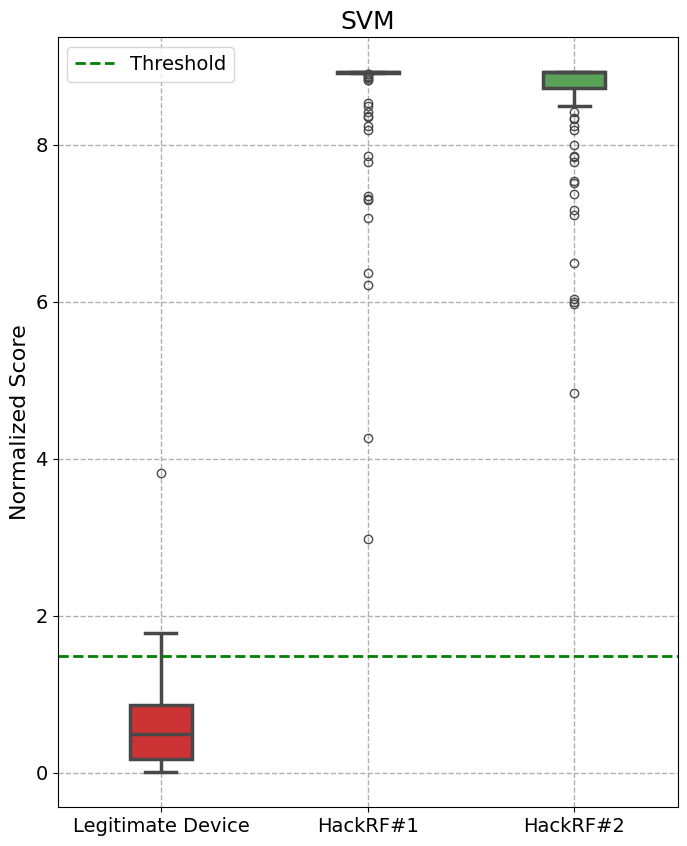

Classification Report for SVM
              precision    recall  f1-score   support

  Legitimate       1.00      0.95      0.97        98
      Attack       0.98      1.00      0.99       200

    accuracy                           0.98       298
   macro avg       0.99      0.97      0.98       298
weighted avg       0.98      0.98      0.98       298



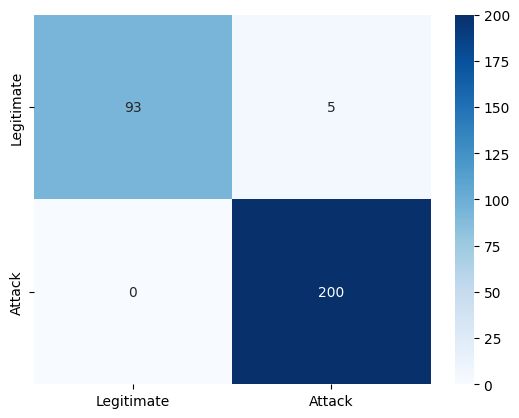

In [ ]:
# One class SVM
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

scaler = StandardScaler()

def train_svm_and_get_scores(X_train, X_test):
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    clf = svm.OneClassSVM(kernel='rbf',nu=0.1)
    clf.fit(X_train)
    scores = clf.decision_function(X_test)
    return scores

X_train, X_test = train_test_split(augmented_legitimate_outputs, test_size=0.3, random_state=42)

aug_legitimate_scores = train_svm_and_get_scores(X_train, X_test)

mu = np.mean(aug_legitimate_scores)
sigma = np.std(aug_legitimate_scores)

legitimate_scores = train_svm_and_get_scores(X_train, legitimate_outputs)

legitimate_scores_norm = np.abs((legitimate_scores - mu) / sigma)

thresholdsvm = np.percentile(legitimate_scores_norm, 95)
legitimate_predictions = (legitimate_scores_norm > thresholdsvm).astype(int)

def evaluate_attack_outputs(attack_outputs, device_name):
    scores = train_svm_and_get_scores(X_train, attack_outputs)
    scores_norm = np.abs((scores - mu) / sigma)
    predictions = (scores_norm > thresholdsvm).astype(int)
    y_test = np.ones(len(attack_outputs))  # True labels for attack outputs
    return scores_norm, predictions, y_test

hackrf1_scores, svmhackrf1_pred, hackrf1_true = evaluate_attack_outputs(attack1_outputs, 'HackRF1')
hackrf2_scores, svmhackrf2_pred, hackrf2_true = evaluate_attack_outputs(attack2_outputs, 'HackRF2')

combined_predictions = np.concatenate([legitimate_predictions,svmhackrf1_pred, svmhackrf2_pred])
true_labels = np.concatenate([np.zeros_like(legitimate_predictions), hackrf1_true, hackrf2_true])

plot_data = [
    legitimate_scores_norm,
    hackrf1_scores,
    hackrf2_scores
]

plt.figure(figsize=(8, 10))
colors = sns.color_palette("Set1", n_colors=3)

sns.boxplot(data=plot_data, width=0.3, palette=colors, linewidth=2.5)
plt.axhline(y=thresholdsvm, color='g', linestyle='--', linewidth=2, label='Threshold')
plt.xticks([0, 1, 2], ['Legitimate Device', 'HackRF#1', 'HackRF#2'], fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Normalized Score', fontsize=16)
plt.title('SVM', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', linewidth=1)
plt.show()

print("Classification Report for SVM")
print(classification_report(true_labels, combined_predictions, target_names=['Legitimate', 'Attack']))

cm = confusion_matrix(true_labels, combined_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Attack'], yticklabels=['Legitimate', 'Attack'])


X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf = svm.OneClassSVM(kernel='rbf',nu=0.1)
clf.fit(X_train)
scores = clf.decision_function(X_test)

## FFT Dataset

Result with aug_legitimate = 700, reconstructed_attack = 700

### MobileNetV1

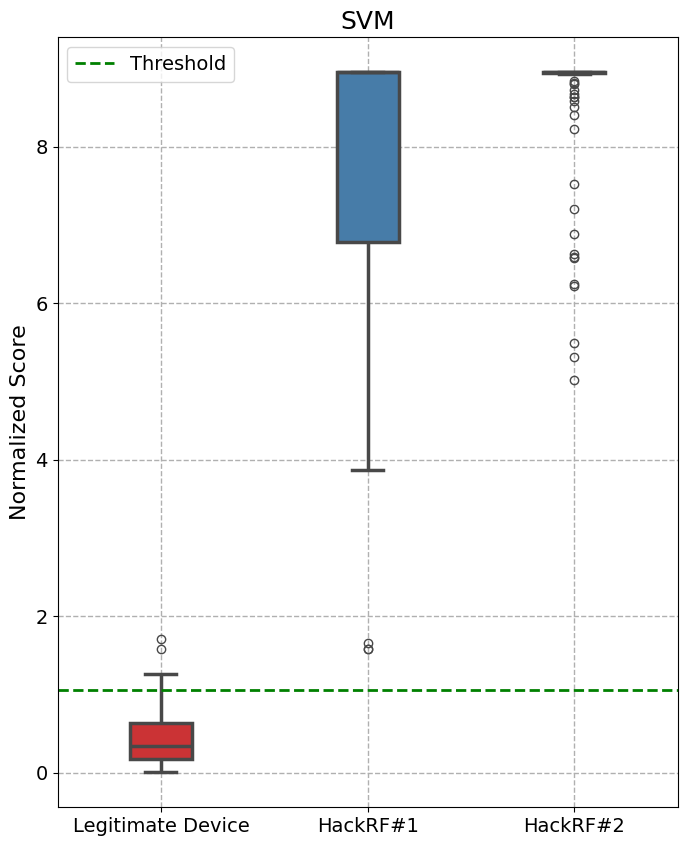

Classification Report for SVM
              precision    recall  f1-score   support

  Legitimate       1.00      0.95      0.97        98
      Attack       0.98      1.00      0.99       200

    accuracy                           0.98       298
   macro avg       0.99      0.97      0.98       298
weighted avg       0.98      0.98      0.98       298



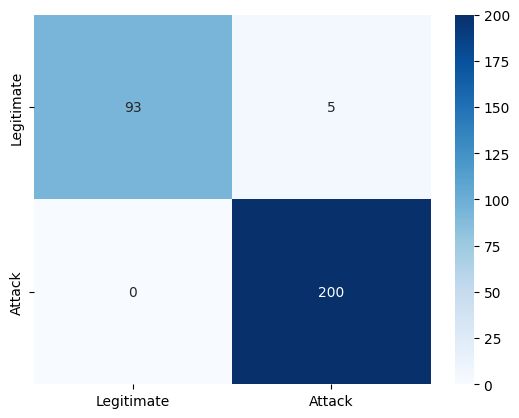

In [ ]:
# One class SVM
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

scaler = StandardScaler()

def train_svm_and_get_scores(X_train, X_test):
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    clf = svm.OneClassSVM(kernel='rbf',nu=0.1)
    clf.fit(X_train)
    scores = clf.decision_function(X_test)
    return scores

X_train, X_test = train_test_split(augmented_legitimate_outputs, test_size=0.3, random_state=42)

aug_legitimate_scores = train_svm_and_get_scores(X_train, X_test)

mu = np.mean(aug_legitimate_scores)
sigma = np.std(aug_legitimate_scores)

legitimate_scores = train_svm_and_get_scores(X_train, legitimate_outputs)

legitimate_scores_norm = np.abs((legitimate_scores - mu) / sigma)

thresholdsvm = np.percentile(legitimate_scores_norm, 95)
legitimate_predictions = (legitimate_scores_norm > thresholdsvm).astype(int)

def evaluate_attack_outputs(attack_outputs, device_name):
    scores = train_svm_and_get_scores(X_train, attack_outputs)
    scores_norm = np.abs((scores - mu) / sigma)
    predictions = (scores_norm > thresholdsvm).astype(int)
    y_test = np.ones(len(attack_outputs))  # True labels for attack outputs
    return scores_norm, predictions, y_test

hackrf1_scores, svmhackrf1_pred, hackrf1_true = evaluate_attack_outputs(attack1_outputs, 'HackRF1')
hackrf2_scores, svmhackrf2_pred, hackrf2_true = evaluate_attack_outputs(attack2_outputs, 'HackRF2')

combined_predictions = np.concatenate([legitimate_predictions,svmhackrf1_pred, svmhackrf2_pred])
true_labels = np.concatenate([np.zeros_like(legitimate_predictions), hackrf1_true, hackrf2_true])

plot_data = [
    legitimate_scores_norm,
    hackrf1_scores,
    hackrf2_scores
]

plt.figure(figsize=(8, 10))
colors = sns.color_palette("Set1", n_colors=3)

sns.boxplot(data=plot_data, width=0.3, palette=colors, linewidth=2.5)
plt.axhline(y=thresholdsvm, color='g', linestyle='--', linewidth=2, label='Threshold')
plt.xticks([0, 1, 2], ['Legitimate Device', 'HackRF#1', 'HackRF#2'], fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Normalized Score', fontsize=16)
plt.title('SVM', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', linewidth=1)
plt.show()

print("Classification Report for SVM")
print(classification_report(true_labels, combined_predictions, target_names=['Legitimate', 'Attack']))

cm = confusion_matrix(true_labels, combined_predictions)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Legitimate', 'Attack'], yticklabels=['Legitimate', 'Attack'])


X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf = svm.OneClassSVM(kernel='rbf',nu=0.1)
clf.fit(X_train)
scores = clf.decision_function(X_test)

### MobileNetV2

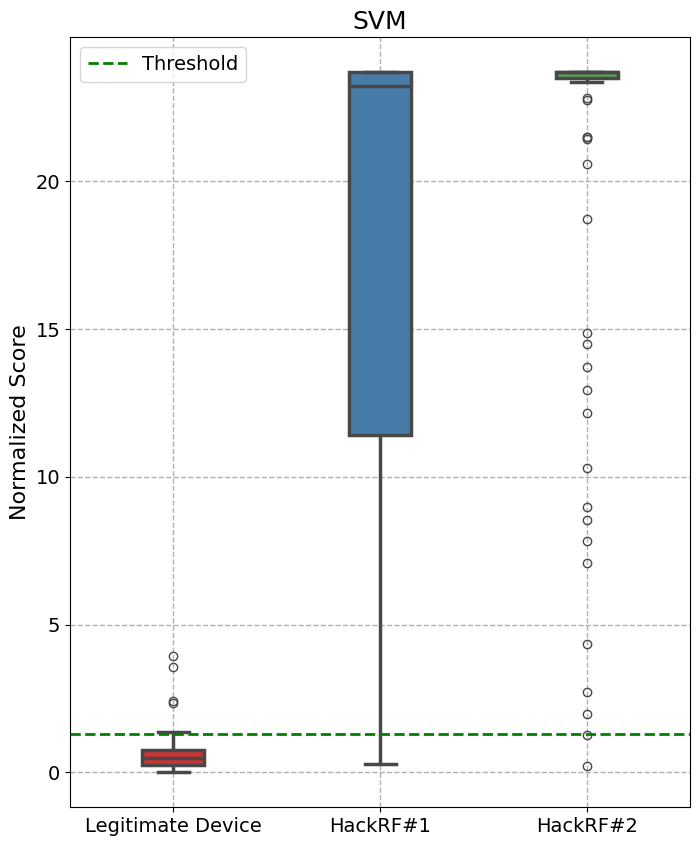

Classification Report for SVM
              precision    recall  f1-score   support

  Legitimate       0.96      0.95      0.95        98
      Attack       0.98      0.98      0.98       200

    accuracy                           0.97       298
   macro avg       0.97      0.96      0.97       298
weighted avg       0.97      0.97      0.97       298



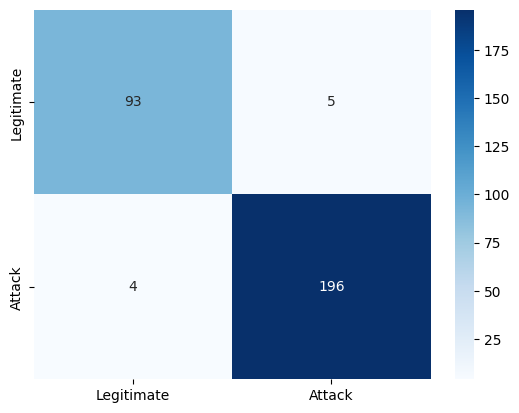

In [17]:
# One class SVM
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

scaler = StandardScaler()

def train_svm_and_get_scores(X_train, X_test):
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    clf = svm.OneClassSVM(kernel='rbf',nu=0.1)
    clf.fit(X_train)
    scores = clf.decision_function(X_test)
    return scores

X_train, X_test = train_test_split(augmented_legitimate_outputs, test_size=0.3, random_state=42)

aug_legitimate_scores = train_svm_and_get_scores(X_train, X_test)

mu = np.mean(aug_legitimate_scores)
sigma = np.std(aug_legitimate_scores)

legitimate_scores = train_svm_and_get_scores(X_train, legitimate_outputs)

legitimate_scores_norm = np.abs((legitimate_scores - mu) / sigma)

thresholdsvm = np.percentile(legitimate_scores_norm, 95)
legitimate_predictions = (legitimate_scores_norm > thresholdsvm).astype(int)

def evaluate_attack_outputs(attack_outputs, device_name):
    scores = train_svm_and_get_scores(X_train, attack_outputs)
    scores_norm = np.abs((scores - mu) / sigma)
    predictions = (scores_norm > thresholdsvm).astype(int)
    y_test = np.ones(len(attack_outputs))  # True labels for attack outputs
    return scores_norm, predictions, y_test

hackrf1_scores, svmhackrf1_pred, hackrf1_true = evaluate_attack_outputs(attack1_outputs, 'HackRF1')
hackrf2_scores, svmhackrf2_pred, hackrf2_true = evaluate_attack_outputs(attack2_outputs, 'HackRF2')

combined_predictions = np.concatenate([legitimate_predictions,svmhackrf1_pred, svmhackrf2_pred])
true_labels = np.concatenate([np.zeros_like(legitimate_predictions), hackrf1_true, hackrf2_true])

plot_data = [
    legitimate_scores_norm,
    hackrf1_scores,
    hackrf2_scores
]

plt.figure(figsize=(8, 10))
colors = sns.color_palette("Set1", n_colors=3)

sns.boxplot(data=plot_data, width=0.3, palette=colors, linewidth=2.5)
plt.axhline(y=thresholdsvm, color='g', linestyle='--', linewidth=2, label='Threshold')
plt.xticks([0, 1, 2], ['Legitimate Device', 'HackRF#1', 'HackRF#2'], fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Normalized Score', fontsize=16)
plt.title('SVM', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', linewidth=1)
plt.show()

print("Classification Report for SVM")
print(classification_report(true_labels, combined_predictions, target_names=['Legitimate', 'Attack']))

cm = confusion_matrix(true_labels, combined_predictions)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Legitimate', 'Attack'], yticklabels=['Legitimate', 'Attack'])


X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf = svm.OneClassSVM(kernel='rbf',nu=0.1)
clf.fit(X_train)
scores = clf.decision_function(X_test)

<Figure size 800x1000 with 0 Axes>

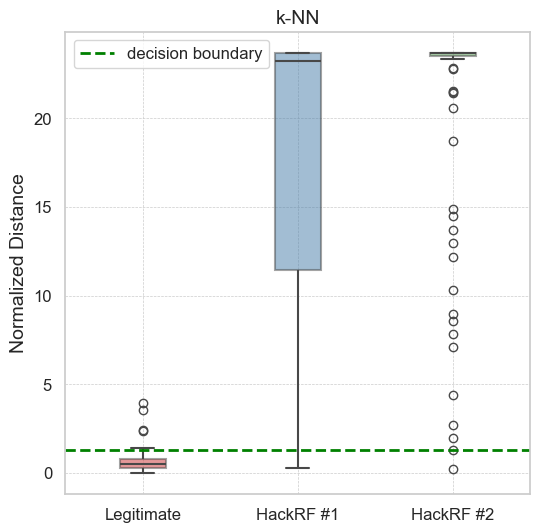

Classification Report for SVM
              precision    recall  f1-score   support

  Legitimate       0.96      0.95      0.95        98
      Attack       0.98      0.98      0.98       200

    accuracy                           0.97       298
   macro avg       0.97      0.96      0.97       298
weighted avg       0.97      0.97      0.97       298



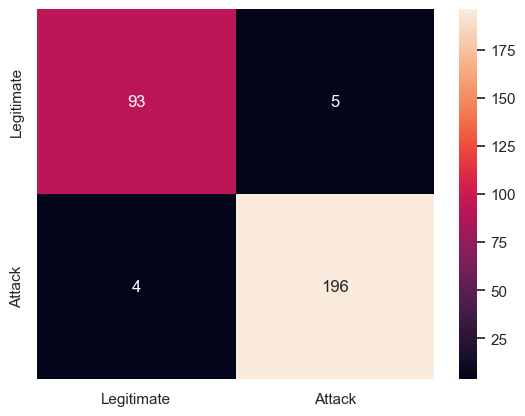

In [56]:
# One class SVM
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

scaler = StandardScaler()

def train_svm_and_get_scores(X_train, X_test):
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    clf = svm.OneClassSVM(kernel='rbf',nu=0.1)
    clf.fit(X_train)
    scores = clf.decision_function(X_test)
    return scores

X_train, X_test = train_test_split(augmented_legitimate_outputs, test_size=0.3, random_state=42)

aug_legitimate_scores = train_svm_and_get_scores(X_train, X_test)

mu = np.mean(aug_legitimate_scores)
sigma = np.std(aug_legitimate_scores)

legitimate_scores = train_svm_and_get_scores(X_train, legitimate_outputs)

legitimate_scores_norm = np.abs((legitimate_scores - mu) / sigma)

thresholdsvm = np.percentile(legitimate_scores_norm, 95)
legitimate_predictions = (legitimate_scores_norm > thresholdsvm).astype(int)

def evaluate_attack_outputs(attack_outputs, device_name):
    scores = train_svm_and_get_scores(X_train, attack_outputs)
    scores_norm = np.abs((scores - mu) / sigma)
    predictions = (scores_norm > thresholdsvm).astype(int)
    y_test = np.ones(len(attack_outputs))  # True labels for attack outputs
    return scores_norm, predictions, y_test

hackrf1_scores, svmhackrf1_pred, hackrf1_true = evaluate_attack_outputs(attack1_outputs, 'HackRF1')
hackrf2_scores, svmhackrf2_pred, hackrf2_true = evaluate_attack_outputs(attack2_outputs, 'HackRF2')

combined_predictions = np.concatenate([legitimate_predictions,svmhackrf1_pred, svmhackrf2_pred])
true_labels = np.concatenate([np.zeros_like(legitimate_predictions), hackrf1_true, hackrf2_true])

plot_data = [
    legitimate_scores_norm,
    hackrf1_scores,
    hackrf2_scores
]

plt.figure(figsize=(8, 10))
colors = sns.color_palette("Set1", n_colors=3)
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
sns.boxplot(data=plot_data, width=0.3, palette=colors, linewidth=1.5, boxprops=dict(alpha=0.5))
plt.axhline(y=thresholdsvm, color='green', linestyle='--', linewidth=2, label='decision boundary')
plt.xticks([0, 1, 2], ['Legitimate', 'HackRF #1', 'HackRF #2'], fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Normalized Distance', fontsize=14)
plt.xlabel('')
plt.title('k-NN', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.show()

print("Classification Report for SVM")
print(classification_report(true_labels, combined_predictions, target_names=['Legitimate', 'Attack']))

cm = confusion_matrix(true_labels, combined_predictions)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Legitimate', 'Attack'], yticklabels=['Legitimate', 'Attack'])


X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf = svm.OneClassSVM(kernel='rbf',nu=0.1)
clf.fit(X_train)
scores = clf.decision_function(X_test)

In [58]:
# with open('svm_mobilenetv2_fft_aug.pkl','wb') as f:
#     pickle.dump(clf,f)

In [ ]:
import pickle

model.to('cpu')

model.eval()

# with open('mobilenetv2_fft.pkl','wb') as f:
#   pickle.dump(model,f)

traced_model = torch.jit.script(model)

# Save the scripted model
traced_model.save("mobilenetv2_fft.pt")

In [ ]:
import torch

# Load the model on CPU
model = torch.jit.load("resnet_fft.pt", map_location=torch.device('cpu'))

# If loading on GPU (if available), specify `cuda`
# model = torch.jit.load("resnet_fft.pt", map_location=torch.device('cuda'))
model.eval()

In [ ]:
!ls

mobilenetv2_fft.pkl  mobilenetv2_fft.pt  model.ipynb  model.py


### IQ Data Constellation Dataset

Results without any proprocessing of the data

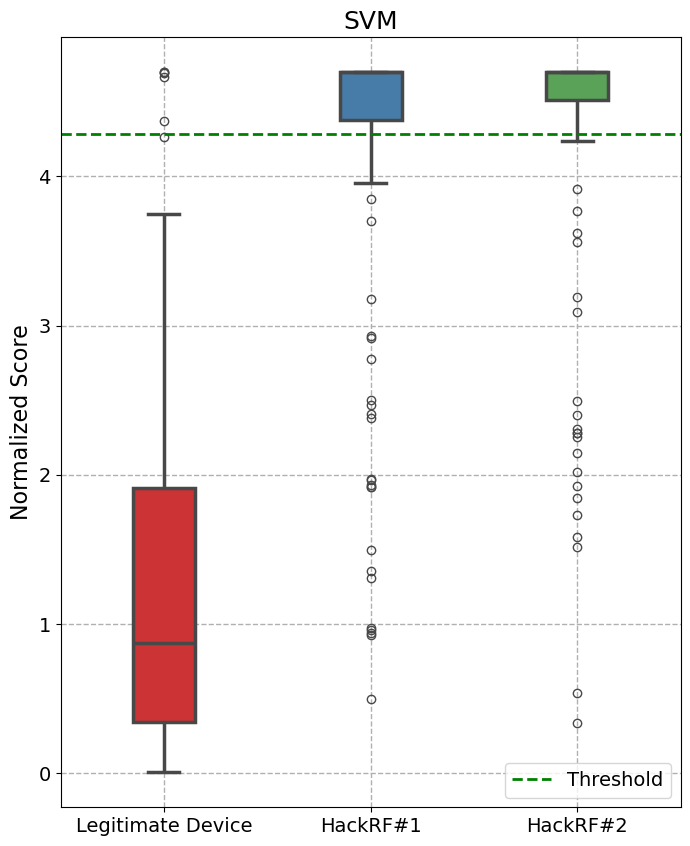

Classification Report for SVM
              precision    recall  f1-score   support

  Legitimate       0.66      0.95      0.78        98
      Attack       0.97      0.77      0.85       200

    accuracy                           0.83       298
   macro avg       0.82      0.86      0.82       298
weighted avg       0.87      0.83      0.83       298



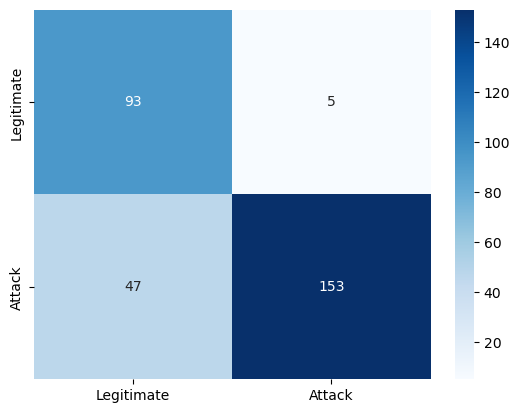

In [ ]:
# One class SVM
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

scaler = StandardScaler()

def train_svm_and_get_scores(X_train, X_test):
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    clf = svm.OneClassSVM(kernel='rbf',nu=0.1)
    clf.fit(X_train)
    scores = clf.decision_function(X_test)
    return scores

X_train, X_test = train_test_split(augmented_legitimate_outputs, test_size=0.3, random_state=42)

aug_legitimate_scores = train_svm_and_get_scores(X_train, X_test)

mu = np.mean(aug_legitimate_scores)
sigma = np.std(aug_legitimate_scores)

legitimate_scores = train_svm_and_get_scores(X_train, legitimate_outputs)

legitimate_scores_norm = np.abs((legitimate_scores - mu) / sigma)

thresholdsvm = np.percentile(legitimate_scores_norm, 95)
legitimate_predictions = (legitimate_scores_norm > thresholdsvm).astype(int)

def evaluate_attack_outputs(attack_outputs, device_name):
    scores = train_svm_and_get_scores(X_train, attack_outputs)
    scores_norm = np.abs((scores - mu) / sigma)
    predictions = (scores_norm > thresholdsvm).astype(int)
    y_test = np.ones(len(attack_outputs))  # True labels for attack outputs
    return scores_norm, predictions, y_test

hackrf1_scores, svmhackrf1_pred, hackrf1_true = evaluate_attack_outputs(attack1_outputs, 'HackRF1')
hackrf2_scores, svmhackrf2_pred, hackrf2_true = evaluate_attack_outputs(attack2_outputs, 'HackRF2')

combined_predictions = np.concatenate([legitimate_predictions,svmhackrf1_pred, svmhackrf2_pred])
true_labels = np.concatenate([np.zeros_like(legitimate_predictions), hackrf1_true, hackrf2_true])

plot_data = [
    legitimate_scores_norm,
    hackrf1_scores,
    hackrf2_scores
]

plt.figure(figsize=(8, 10))
colors = sns.color_palette("Set1", n_colors=3)

sns.boxplot(data=plot_data, width=0.3, palette=colors, linewidth=2.5)
plt.axhline(y=thresholdsvm, color='g', linestyle='--', linewidth=2, label='Threshold')
plt.xticks([0, 1, 2], ['Legitimate Device', 'HackRF#1', 'HackRF#2'], fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Normalized Score', fontsize=16)
plt.title('SVM', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', linewidth=1)
plt.show()

print("Classification Report for SVM")
print(classification_report(true_labels, combined_predictions, target_names=['Legitimate', 'Attack']))

cm = confusion_matrix(true_labels, combined_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Attack'], yticklabels=['Legitimate', 'Attack'])


X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf = svm.OneClassSVM(kernel='rbf',nu=0.1)
clf.fit(X_train)
scores = clf.decision_function(X_test)

In [ ]:
with open('svm_constellation.pkl','wb') as f:
    pickle.dump(clf,f)

In [ ]:
print(combined_predictions[:len(legitimate_predictions)])
print(true_labels[:len(legitimate_predictions)])
print(len(combined_predictions),len(true_labels))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
298 298


In [ ]:
import pickle

with open('resnet_constellation.pkl','wb') as f:
    pickle.dump(model,f)

### ResNet with Constellation dataset:

Dataset type: constellation

dataset size: 318 160 80 40

Training...

Epoch [1/7], Descriptive Loss: 14.7895, Compactness Loss: 0.7546

Epoch [2/7], Descriptive Loss: 1.0184, Compactness Loss: 0.2851

Epoch [3/7], Descriptive Loss: 0.4831, Compactness Loss: 0.1227

Epoch [4/7], Descriptive Loss: 0.2445, Compactness Loss: 0.0638

Epoch [5/7], Descriptive Loss: 0.1668, Compactness Loss: 0.0481

Epoch [6/7], Descriptive Loss: 0.1497, Compactness Loss: 0.0555

Epoch [7/7], Descriptive Loss: 0.0930, Compactness Loss: 0.0433

training runtime: 164.53897309303284

Testing...

Epoch [1/7], Descriptive Loss: 0.0612, Compactness Loss: 0.0179

Epoch [2/7], Descriptive Loss: 0.1637, Compactness Loss: 0.0148

Epoch [3/7], Descriptive Loss: 0.1032, Compactness Loss: 0.0119

Epoch [4/7], Descriptive Loss: 0.0569, Compactness Loss: 0.0142

Epoch [5/7], Descriptive Loss: 0.0844, Compactness Loss: 0.0181

Epoch [6/7], Descriptive Loss: 0.1064, Compactness Loss: 0.0149

Epoch [7/7], Descriptive Loss: 0.0401, Compactness Loss: 0.0120

testing runtime: 54.514583110809326

### ResNet with FFT dataset:

Dataset type: fft/

Loading datasets...

Epoch [1/10], Descriptive Loss: 18.1103, Compactness Loss: 0.2922

Epoch [2/10], Descriptive Loss: 0.1142, Compactness Loss: 0.2528

Epoch [3/10], Descriptive Loss: 0.0207, Compactness Loss: 0.0497

Epoch [4/10], Descriptive Loss: 0.0413, Compactness Loss: 0.0239

Epoch [5/10], Descriptive Loss: 0.0184, Compactness Loss: 0.0168

Epoch [6/10], Descriptive Loss: 0.0121, Compactness Loss: 0.0118

Epoch [7/10], Descriptive Loss: 0.0082, Compactness Loss: 0.0106

Epoch [8/10], Descriptive Loss: 0.0032, Compactness Loss: 0.0088

Epoch [9/10], Descriptive Loss: 0.0074, Compactness Loss: 0.0069

Epoch [10/10], Descriptive Loss: 0.0030, Compactness Loss: 0.0070

runtime: 335.7496831417084

torch.Size([3, 224, 224])


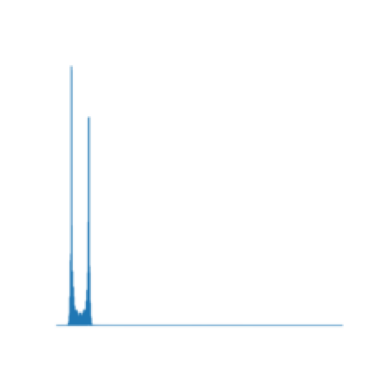

In [ ]:
signal,label = reference_loader.dataset[0]
print(signal.shape)
signal = signal.permute(1, 2, 0)
signal = signal.numpy()
import matplotlib.pyplot as plt
plt.imshow(signal)
plt.axis('off')
plt.show()

torch.Size([3, 224, 224])


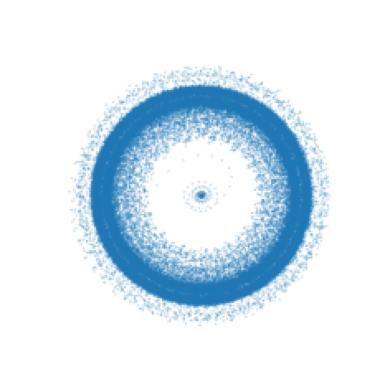

In [ ]:
signal,label = reference_loader.dataset[0]
print(signal.shape)
signal = signal.permute(1, 2, 0)
signal = signal.numpy()
import matplotlib.pyplot as plt
plt.imshow(signal)
plt.axis('off')
plt.show()

In [ ]:
legitimate_outputs[0]

tensor([ 8.9264,  5.6583, -5.2948, -4.6221, -5.1230, -5.1969, -4.9833, -4.9316,
        -4.5593, -5.2770, -5.3424, -4.7094, -5.1120, -5.0604, -5.4707, -5.1534,
        -4.8021, -5.3580, -4.8726, -4.4398, -5.1170, -4.9106, -5.2793, -4.3377,
        -4.8098, -5.4274, -4.1280, -4.8910, -4.9870, -5.0928, -4.7775, -4.6501,
        -5.1560, -5.2078, -4.8919, -5.3861, -5.2091, -5.1071, -5.0725, -5.2121,
        -5.0326, -4.7922, -5.1628, -4.7052, -5.2918, -4.8985, -4.8160, -4.4672,
        -4.9549, -5.0205, -5.3970, -4.3982, -5.4711, -4.5430, -5.1819, -5.3152,
        -4.6268, -4.9665, -4.9250, -5.2664, -4.0054, -4.7220, -4.5741, -4.3203,
        -5.5024, -5.2606, -4.8297, -4.6773, -5.0386, -4.9047, -4.9692, -5.0460,
        -4.7830, -4.9793, -4.6016, -5.0610, -5.2182, -5.0303, -5.0210, -4.9148,
        -4.8849, -4.8234, -4.9780, -5.4632, -4.4189, -4.5647, -5.2645, -5.1533,
        -4.6342, -4.5902, -5.1957, -4.7345, -4.5337, -5.0994, -4.9600, -5.2195,
        -5.2457, -5.0870, -5.1916, -5.23

In [ ]:
# plot the correlation matrix with the legitimate and attack signals
import seaborn as sns

def plot_correlation_matrix(data, title):
    corr = np.corrcoef(data)
    sns.heatmap(corr, xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.show()

combined_outputs = np.concatenate([legitimate_outputs,augmented_legitimate_outputs, attack1_outputs, attack2_outputs])

plot_correlation_matrix(combined_outputs, 'Legitimate and Attack Signals Correlation Matrix')

NameError: name 'legitimate_outputs' is not defined

In [ ]:
# DO pca
from sklearn.decomposition import PCA

def plot_pca(data, title):
    pca = PCA(n_components=400)
    principal_components = pca.fit_transform(data)
    plt.scatter(principal_components[:len(legitimate_outputs), 2], principal_components[:len(legitimate_outputs), 3], label='Legitimate',s=10)
    plt.scatter(principal_components[len(legitimate_outputs):, 2], principal_components[len(legitimate_outputs):, 3], label='Attack',s=10)
    plt.title(title)
    plt.show()
    return principal_components

combined_pca = plot_pca(combined_outputs, 'PCA')
legitimate_pca = combined_pca[:len(legitimate_outputs)]
augmented_legitimate_pca = combined_pca[len(legitimate_outputs):len(augmented_legitimate_outputs)]
attack1_pca = combined_pca[len(legitimate_outputs) + len(augmented_legitimate_outputs):len(legitimate_outputs) + len(augmented_legitimate_outputs) +len(attack1_dataset)]
attack2_pca = combined_pca[len(legitimate_outputs) + len(augmented_legitimate_outputs)+len(attack1_dataset):]
print(len(legitimate_pca), len(attack1_pca), len(attack2_pca))

NameError: name 'combined_outputs' is not defined

In [ ]:
# One class SVM
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

scaler = StandardScaler()

def train_svm_and_get_scores(X_train, X_test):
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    clf = svm.OneClassSVM(kernel='rbf',nu=0.04)
    clf.fit(X_train)
    scores = clf.decision_function(X_test)
    return scores

X_train, X_test = train_test_split(augmented_legitimate_pca, test_size=0.3, random_state=42)

aug_legitimate_scores = train_svm_and_get_scores(X_train, X_test)

mu = np.mean(aug_legitimate_scores)
sigma = np.std(aug_legitimate_scores)

legitimate_scores = train_svm_and_get_scores(X_train, legitimate_pca)

legitimate_scores_norm = np.abs((legitimate_scores - mu) / sigma)

thresholdsvm = np.percentile(legitimate_scores_norm, 95)
legitimate_predictions = (legitimate_scores_norm > thresholdsvm).astype(int)

def evaluate_attack_outputs(attack_outputs, device_name):
    scores = train_svm_and_get_scores(X_train, attack_outputs)
    scores_norm = np.abs((scores - mu) / sigma)
    predictions = (scores_norm > thresholdsvm).astype(int)
    y_test = np.ones(len(attack_outputs))  # True labels for attack outputs
    return scores_norm, predictions, y_test

hackrf1_scores, svmhackrf1_pred, hackrf1_true = evaluate_attack_outputs(attack1_pca, 'HackRF1')
hackrf2_scores, svmhackrf2_pred, hackrf2_true = evaluate_attack_outputs(attack2_pca, 'HackRF2')

combined_predictions = np.concatenate([legitimate_predictions,svmhackrf1_pred, svmhackrf2_pred])
true_labels = np.concatenate([np.zeros_like(legitimate_predictions), hackrf1_true, hackrf2_true])

plot_data = [
    legitimate_scores_norm,
    hackrf1_scores,
    hackrf2_scores
]

plt.figure(figsize=(8, 10))
colors = sns.color_palette("Set1", n_colors=3)

sns.boxplot(data=plot_data, width=0.3, palette=colors, linewidth=2.5)
plt.axhline(y=thresholdsvm, color='g', linestyle='--', linewidth=2, label='Threshold')
plt.xticks([0, 1, 2], ['Legitimate Device', 'HackRF#1', 'HackRF#2'], fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Normalized Score', fontsize=16)
plt.title('SVM', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', linewidth=1)
plt.show()

print("Classification Report for SVM")
print(classification_report(true_labels, combined_predictions, target_names=['Legitimate', 'Attack']))

cm = confusion_matrix(true_labels, combined_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Attack'], yticklabels=['Legitimate', 'Attack'])

NameError: name 'augmented_legitimate_pca' is not defined

### Dataset Creation

In [ ]:
# datasets: legitimate, reconstructed, attack, augmented legitimate signals
import numpy as np

datasets_directory = '../datasets/signals/'

with open(datasets_directory + 'reconstructed.npy','rb') as f:
    reconstructed_attack = []
    signal = np.load(f)
    while True:
        try:
            signal = np.load(f)
            reconstructed_attack.append(signal)
        except:
            break

with open(datasets_directory + 'legitimate.npy','rb') as f:
    legitimate = []
    signal = np.load(f)
    while True:
        try:
            signal = np.load(f)
            legitimate.append(signal)
        except:
            break

with open(datasets_directory + 'attack1.npy','rb') as f:
    attack1 = []
    while True:
        try:
            signal = np.load(f)
            attack1.append(signal)
        except:
            break

with open(datasets_directory + 'attack2.npy','rb') as f:
    attack2 = []
    while True:
        try:
            signal = np.load(f)
            attack2.append(signal)
        except:
            break

with open(datasets_directory + 'augmented_legitimate.npy','rb') as f:
    augmented_legitimate = []
    while True:
        try:
            signal = np.load(f)
            augmented_legitimate.append(signal)
        except:
            break

augmented_legitimate = [(signal, 0) for signal in augmented_legitimate]
reconstructed_attack = [(signal, 1) for signal in reconstructed_attack]
attack1 = [(signal, 1) for signal in attack1]
attack2 = [(signal, 1) for signal in attack2]
legitimate = [(signal, 0) for signal in legitimate]
reference_dataset = augmented_legitimate + reconstructed_attack
target_dataset = augmented_legitimate

In [ ]:
signal

array([-6.48543101e-06-2.56189306e-06j, -1.91223886e-05-3.39634792e-05j,
       -5.12657907e-05-9.05890091e-05j, ...,
        4.38015593e-01-5.66632568e-01j,  6.06857473e-01-3.79409157e-01j,
        6.97994761e-01-1.44818695e-01j])

In [ ]:
from helpers.fft_gen import gen_fft_dataset

legitimate_fft = gen_fft_dataset(legitimate)
reconstructed_attack_fft = gen_fft_dataset(reconstructed_attack)
attack1_fft = gen_fft_dataset(attack1)
attack2_fft = gen_fft_dataset(attack2)
augmented_legitimate_fft = gen_fft_dataset(augmented_legitimate)

fft_directory = '../datasets/fft/'

with open(fft_directory + 'legitimate.npy', 'wb') as f:
    for signal in legitimate_fft:
        np.save(f, signal[0])

with open(fft_directory + 'reconstructed.npy', 'wb') as f:
    for signal in reconstructed_attack_fft:
        np.save(f, signal[0])

with open(fft_directory + 'attack1.npy', 'wb') as f:
    for signal in attack1_fft:
        np.save(f, signal[0])

with open(fft_directory + 'attack2.npy', 'wb') as f:
    for signal in attack2_fft:
        np.save(f, signal[0])

with open(fft_directory + 'augmented_legitimate.npy', 'wb') as f:
    for signal in augmented_legitimate_fft:
        np.save(f, signal[0])


In [ ]:
from helpers.constellation_gen import gen_constellation_dataset
legitimate_constellation = gen_constellation_dataset(legitimate)
reconstructed_attack_constellation = gen_constellation_dataset(reconstructed_attack)
attack1_constellation = gen_constellation_dataset(attack1)
attack2_constellation = gen_constellation_dataset(attack2)
augmented_legitimate_constellation = gen_constellation_dataset(augmented_legitimate)

constellation_directory = '../datasets/constellation/'

with open(constellation_directory + 'legitimate.npy', 'wb') as f:
    for signal in legitimate_constellation:
        np.save(f, signal[0])

with open(constellation_directory + 'reconstructed.npy', 'wb') as f:
    for signal in reconstructed_attack_constellation:
        np.save(f, signal[0])

with open(constellation_directory + 'attack1.npy', 'wb') as f:
    for signal in attack1_constellation:
        np.save(f, signal[0])

with open(constellation_directory + 'attack2.npy', 'wb') as f:
    for signal in attack2_constellation:
        np.save(f, signal[0])

with open(constellation_directory + 'augmented_legitimate.npy', 'wb') as f:
    for signal in augmented_legitimate_constellation:
        np.save(f, signal[0])


### Loss plot

In [1]:
import pickle
import torch
import torch.nn as nn
import pytorchcv

class DOCMobileNetV1(nn.Module):
    def __init__(self, num_classes):
        super(DOCMobileNetV1, self).__init__()
        # Load pretrained MobileNetV1 from pytorchcv
        self.mobilenet = ptcv_get_model("mobilenet_w1", pretrained=True)
        num_features = self.mobilenet.output.in_features
        self.mobilenet.output = nn.Linear(num_features, num_classes)
        self.losses = []

    def forward(self, x):
        return self.mobilenet(x)
    
class DOCMobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super(DOCMobileNetV2, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        num_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier[1] = nn.Linear(num_features, num_classes)
        self.losses = []

    def forward(self, x):
        return self.mobilenet(x)

with open('mobilenetv1_fft_aug.pkl','rb') as f:
  mb1 = pickle.load(f)

with open('mobilenetv2_fft_aug.pkl','rb') as f:
  mb2 = pickle.load(f)

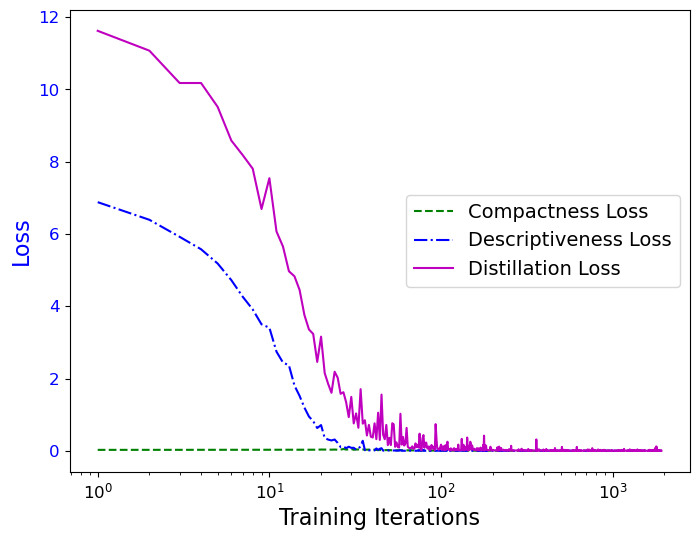

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    'font.size': 14,           # General font size
    'axes.titlesize': 18,      # Title font size
    'axes.labelsize': 16,      # Axis label font size
    'legend.fontsize': 14,     # Legend font size
    'xtick.labelsize': 12,     # X-axis tick font size
    'ytick.labelsize': 12      # Y-axis tick font size
})

compactness_loss = [loss[1] for epoch_losses in mb1.losses for loss in epoch_losses]
descriptiveness_loss = [loss[2] for epoch_losses in mb1.losses for loss in epoch_losses]
distillation_loss = [loss[0] for epoch_losses in mb1.losses for loss in epoch_losses]
iterations = np.arange(1, len(distillation_loss) + 1)
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(iterations, compactness_loss, 'g--', label='Compactness Loss')
ax1.plot(iterations, descriptiveness_loss, 'b-.', label='Descriptiveness Loss')
ax1.plot(iterations, distillation_loss, 'm-', label='Distillation Loss')
ax1.set_xlabel('Training Iterations')
ax1.set_ylabel('Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='center right')
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.show()


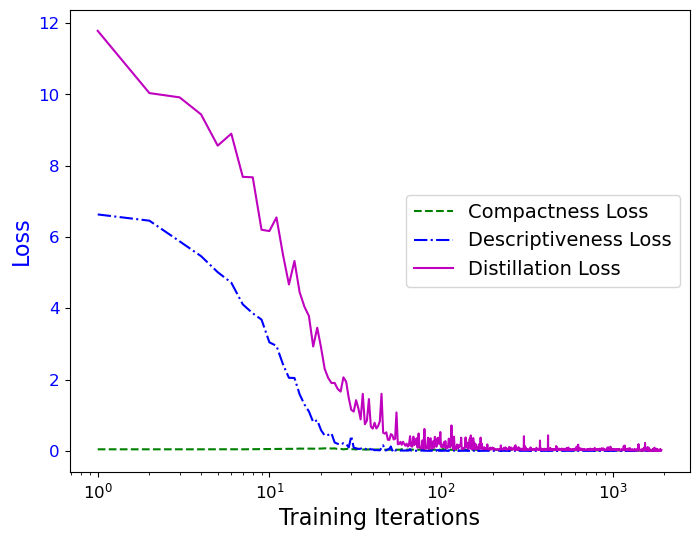

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    'font.size': 14,           # General font size
    'axes.titlesize': 18,      # Title font size
    'axes.labelsize': 16,      # Axis label font size
    'legend.fontsize': 14,     # Legend font size
    'xtick.labelsize': 12,     # X-axis tick font size
    'ytick.labelsize': 12      # Y-axis tick font size
})

compactness_loss = [loss[1] for epoch_losses in mb2.losses for loss in epoch_losses]
descriptiveness_loss = [loss[2] for epoch_losses in mb2.losses for loss in epoch_losses]
distillation_loss = [loss[0] for epoch_losses in mb2.losses for loss in epoch_losses]
iterations = np.arange(1, len(distillation_loss) + 1)
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(iterations, compactness_loss, 'g--', label='Compactness Loss')
ax1.plot(iterations, descriptiveness_loss, 'b-.', label='Descriptiveness Loss')
ax1.plot(iterations, distillation_loss, 'm-', label='Distillation Loss')
ax1.set_xlabel('Training Iterations')
ax1.set_ylabel('Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='center right')
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.show()